In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)

obj_id type  redshift           mjd         mjd_0         t  \
0      ZTF18aakuewf  Ibn    0.0636  58226.340532  58226.340532  0.000000   
1      ZTF18aakuewf  Ibn    0.0636  58226.390513  58226.340532  0.049981   
2      ZTF18aakuewf  Ibn    0.0636  58226.440494  58226.340532  0.099961   
3      ZTF18aakuewf  Ibn    0.0636  58226.490474  58226.340532  0.149942   
4      ZTF18aakuewf  Ibn    0.0636  58226.540455  58226.340532  0.199923   
...             ...  ...       ...           ...           ...       ...   
36853  ZTF24aascytf   II    0.0380  60480.172223  60476.217836  3.954388   
36854  ZTF24aascytf   II    0.0380  60480.181356  60476.217836  3.963520   
36855  ZTF24aascytf   II    0.0380  60480.190488  60476.217836  3.972653   
36856  ZTF24aascytf   II    0.0380  60480.199621  60476.217836  3.981785   
36857  ZTF24aascytf   II    0.0380  60480.208754  60476.217836  3.990918   

        mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  ...  abs_mag_ztfi  \
0      18.516426    -13.834339        0.235213  18.914558  ...           NaN   
1      18.496472    -13.854294        0.224712  18.882957  ...           NaN   
2      18.476866    -13.873900        0.214622  18.852310  ...           NaN   
3      18.457598    -13.893168        0.204923  18.822692  ...           NaN   
4      18.438655    -13.912110        0.195597  18.794102  ...           NaN   
...          ...           ...             ...        ...  ...           ...   
36853  20.793887    -10.398977        1.026317  20.312205  ...    -11.090834   
36854  20.795950    -10.396914        1.034748  20.315167  ...    -11.087963   
36855  20.797930    -10.394934        1.043002  20.318076  ...    -11.085116   
36856  20.799828    -10.393036        1.051076  20.320933  ...    -11.082294   
36857  20.801644    -10.391220        1.058968  20.323738  ...    -11.079496   

       mag_error_ztfi   flux_ztfg  flux_error_ztfg   flux_ztfr  \
0                 NaN  142.373588        30.843697   98.668109   
1                 NaN  145.014457        30.013242  101.582057   
2                 NaN  147.656847        29.187955  104.490322   
3                 NaN  150.300692        28.367979  107.379974   
4                 NaN  152.945927        27.553467  110.245034   
...               ...         ...              ...         ...   
36853        0.700057   17.476125        16.519709   27.234410   
36854        0.703241   17.442947        16.623801   27.160225   
36855        0.706375   17.411165        16.725866   27.087546   
36856        0.709458   17.380760        16.825905   27.016360   
36857        0.712489   17.351715        16.923919   26.946655   

       flux_error_ztfr  flux_ztfi  flux_error_ztfi  rise  fade  
0             1.246373        NaN              NaN     y     y  
1             1.080243        NaN              NaN     y     y  
2             1.080575        NaN              NaN     y     y  
3             1.219787        NaN              NaN     y     y  
4             1.433721        NaN              NaN     y     y  
...                ...        ...              ...   ...   ...  
36853        15.860492  33.051259        21.310669     y     y  
36854        15.918773  32.963971        21.351059     y     y  
36855        15.974491  32.877653        21.390053     y     y  
36856        16.027639  32.792302        21.427639     y     y  
36857        16.078209  32.707920        21.463807     y     y  

[36858 rows x 23 columns]

obj_id type redshift           mjd         mjd_0         t  \
0     ZTF18aakuewf  Ibn   0.0636  58226.340532  58226.340532  0.000000   
1     ZTF18aakuewf  Ibn   0.0636  58226.358623  58226.340532  0.018090   
2     ZTF18aakuewf  Ibn   0.0636  58226.378947  58226.340532  0.038414   
3     ZTF18aakuewf  Ibn   0.0636  58226.414456  58226.340532  0.073924   
4     ZTF18aakuewf  Ibn   0.0636  58226.415394  58226.340532  0.074861   
...            ...  ...      ...           ...           ...       ...   
5849  ZTF24aascytf   II    0.038  60479.408218  60476.217836  3.190382   
5850  ZTF24aascytf   II    0.038  60481.354132  60476.217836  5.136296   
5851  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5852  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5853  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   

       mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0           NaN           NaN             NaN  18.961000    -13.389765   
1           NaN           NaN             NaN  18.871901    -13.478865   
2           NaN           NaN             NaN  18.922800    -13.427966   
3           NaN           NaN             NaN  18.856501    -13.494265   
4           NaN           NaN             NaN  18.849501    -13.501265   
...         ...           ...             ...        ...           ...   
5849  20.327264      -10.8656        0.156657        NaN           NaN   
5850        NaN           NaN             NaN  20.379625    -10.813239   
5851        NaN           NaN             NaN  20.009301    -11.183563   
5852        NaN           NaN             NaN  20.009281    -11.183583   
5853        NaN           NaN             NaN  20.002291    -11.190573   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  
0           0.031726       NaN           NaN             NaN  
1           0.029414       NaN           NaN             NaN  
2           0.033493       NaN           NaN             NaN  
3           0.031619       NaN           NaN             NaN  
4           0.033379       NaN           NaN             NaN  
...              ...       ...           ...             ...  
5849             NaN       NaN           NaN             NaN  
5850        0.187584       NaN           NaN             NaN  
5851        0.197632       NaN           NaN             NaN  
5852        0.197632       NaN           NaN             NaN  
5853        0.131999       NaN           NaN             NaN  

[5854 rows x 15 columns]

In [13]:
df.columns

Index(['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
       'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
       'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',
       'flux_ztfg', 'flux_error_ztfg', 'flux_ztfr', 'flux_error_ztfr',
       'flux_ztfi', 'flux_error_ztfi', 'rise', 'fade'],
      dtype='object')

In [27]:
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]

data = []

for idx, row in df_observed.iterrows():#tqdm(df_observed.iterrows(), total=df_observed.shape[0]):
    filter_ = row['filter']
    # print(row.mag)
    data.append(pd.Series({
        'obj_id': row.obj_id,
        'type': row.type,
        'redshift': row.redshift,
        'mjd': row.mjd,
        'mjd_0': row.mjd_0,
        't': row.t,
        f'mag_{filter_}': row.mag,
        f'abs_mag_{filter_}': row.absmag,
        f'mag_error_{filter_}': row.magerr
    }))
    

df_obs_matched = pd.DataFrame(data, columns=common_columns)
df_obs_matched = df_obs_matched.sort_values(by=['obj_id', 'mjd']).reset_index(drop=True)
df_obs_matched

obj_id type redshift           mjd         mjd_0         t  \
0     ZTF18aakuewf  Ibn   0.0636  58226.340532  58226.340532  0.000000   
1     ZTF18aakuewf  Ibn   0.0636  58226.358623  58226.340532  0.018090   
2     ZTF18aakuewf  Ibn   0.0636  58226.378947  58226.340532  0.038414   
3     ZTF18aakuewf  Ibn   0.0636  58226.414456  58226.340532  0.073924   
4     ZTF18aakuewf  Ibn   0.0636  58226.415394  58226.340532  0.074861   
...            ...  ...      ...           ...           ...       ...   
5849  ZTF24aascytf   II    0.038  60479.408218  60476.217836  3.190382   
5850  ZTF24aascytf   II    0.038  60481.354132  60476.217836  5.136296   
5851  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5852  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5853  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   

       mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0           NaN           NaN             NaN  18.961000    -13.389765   
1           NaN           NaN             NaN  18.871901    -13.478865   
2           NaN           NaN             NaN  18.922800    -13.427966   
3           NaN           NaN             NaN  18.856501    -13.494265   
4           NaN           NaN             NaN  18.849501    -13.501265   
...         ...           ...             ...        ...           ...   
5849  20.327264      -10.8656        0.156657        NaN           NaN   
5850        NaN           NaN             NaN  20.379625    -10.813239   
5851        NaN           NaN             NaN  20.009301    -11.183563   
5852        NaN           NaN             NaN  20.009281    -11.183583   
5853        NaN           NaN             NaN  20.002291    -11.190573   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  
0           0.031726       NaN           NaN             NaN  
1           0.029414       NaN           NaN             NaN  
2           0.033493       NaN           NaN             NaN  
3           0.031619       NaN           NaN             NaN  
4           0.033379       NaN           NaN             NaN  
...              ...       ...           ...             ...  
5849             NaN       NaN           NaN             NaN  
5850        0.187584       NaN           NaN             NaN  
5851        0.197632       NaN           NaN             NaN  
5852        0.197632       NaN           NaN             NaN  
5853        0.131999       NaN           NaN             NaN  

[5854 rows x 15 columns]

In [30]:
df_obs_matched

obj_id type redshift           mjd         mjd_0         t  \
0     ZTF18aakuewf  Ibn   0.0636  58226.340532  58226.340532  0.000000   
1     ZTF18aakuewf  Ibn   0.0636  58226.358623  58226.340532  0.018090   
2     ZTF18aakuewf  Ibn   0.0636  58226.378947  58226.340532  0.038414   
3     ZTF18aakuewf  Ibn   0.0636  58226.414456  58226.340532  0.073924   
4     ZTF18aakuewf  Ibn   0.0636  58226.415394  58226.340532  0.074861   
...            ...  ...      ...           ...           ...       ...   
5849  ZTF24aascytf   II    0.038  60479.408218  60476.217836  3.190382   
5850  ZTF24aascytf   II    0.038  60481.354132  60476.217836  5.136296   
5851  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5852  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   
5853  ZTF24aascytf   II    0.038  60485.341238  60476.217836  9.123403   

       mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0           NaN           NaN             NaN  18.961000    -13.389765   
1           NaN           NaN             NaN  18.871901    -13.478865   
2           NaN           NaN             NaN  18.922800    -13.427966   
3           NaN           NaN             NaN  18.856501    -13.494265   
4           NaN           NaN             NaN  18.849501    -13.501265   
...         ...           ...             ...        ...           ...   
5849  20.327264      -10.8656        0.156657        NaN           NaN   
5850        NaN           NaN             NaN  20.379625    -10.813239   
5851        NaN           NaN             NaN  20.009301    -11.183563   
5852        NaN           NaN             NaN  20.009281    -11.183583   
5853        NaN           NaN             NaN  20.002291    -11.190573   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  
0           0.031726       NaN           NaN             NaN  
1           0.029414       NaN           NaN             NaN  
2           0.033493       NaN           NaN             NaN  
3           0.031619       NaN           NaN             NaN  
4           0.033379       NaN           NaN             NaN  
...              ...       ...           ...             ...  
5849             NaN       NaN           NaN             NaN  
5850        0.187584       NaN           NaN             NaN  
5851        0.197632       NaN           NaN             NaN  
5852        0.197632       NaN           NaN             NaN  
5853        0.131999       NaN           NaN             NaN  

[5854 rows x 15 columns]

In [25]:
df_obs_matched.describe()

mjd         mjd_0            t     mag_ztfg  abs_mag_ztfg  \
count   5854.000000   5854.000000  5854.000000  2892.000000   2892.000000   
mean   59385.333334  59221.364006   163.969328    18.900507     -5.942700   
std      604.602910    696.374830   373.454133     1.304518     12.011028   
min    58226.340532  58226.340532     0.000000    12.617463    -21.005069   
25%    59013.593131  58376.478380    11.982674    18.387452    -12.631365   
50%    59347.378941  59215.423935    31.947188    19.468150    -11.667619   
75%    59870.359549  59827.291111    62.006942    19.721926     -9.458671   
max    60485.341238  60476.217836  2143.133345    20.995899     20.719000   

       mag_error_ztfg     mag_ztfr  abs_mag_ztfr  mag_error_ztfr    mag_ztfi  \
count     2892.000000  2553.000000   2553.000000     2553.000000  409.000000   
mean         0.120218    18.518937     -5.089979        0.099692   18.466774   
std          0.053439     1.188177     12.347553        0.049240    1.251653   
min          0.012939    12.988959    -22.412789        0.014615   13.957964   
25%          0.073562    17.870916    -11.995894        0.057845   17.715570   
50%          0.129136    18.760500    -11.130284        0.092891   18.665192   
75%          0.161048    19.309986     -8.900338        0.134734   19.179676   
max          0.217078    21.140490     20.638800        0.216786   20.812000   

       abs_mag_ztfi  mag_error_ztfi  
count    409.000000      409.000000  
mean      -2.376585        0.114390  
std       13.376137        0.055285  
min      -20.811843        0.022953  
25%      -11.405237        0.064346  
50%      -10.459984        0.108922  
75%       16.274821        0.161189  
max       19.914742        0.217026

In [3]:


# common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
#     'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
#     'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
# df_obs_matched = pd.DataFrame(columns=common_columns)
# for row in tqdm(df_observed.iterrows(), total=df_observed.shape[0]):
#     idx, row = row
#     df_dummy = pd.DataFrame(columns=common_columns)
#     df_dummy['obj_id'] = [row.obj_id]
#     df_dummy['type'] = [row.type]
#     df_dummy['redshift'] = [row.redshift]
#     df_dummy['mjd'] = [row.mjd]
#     df_dummy['mjd_0'] = [row.mjd_0]
#     df_dummy['t'] = [row.t]
#     filter_ = row.filter
#     df_dummy[f'mag_{filter_}'] = [row.mag]
#     df_dummy[f'abs_mag_{filter_}'] = [row.absmag]
#     df_dummy[f'mag_error_{filter_}'] = [row.magerr]
#     df_obs_matched = pd.concat([df_obs_matched, df_dummy], ignore_index=True)

# df_obs_matched = df_obs_matched.reset_index(drop=True)
# df_obs_matched = df_obs_matched.sort_values(by=['obj_id', 'mjd'])

 15%|█▍        | 867/5854 [01:25<08:10, 10.17it/s]


KeyboardInterrupt: 

In [24]:
df_obs_matched

mjd type        obj_id         mjd_0         t redshift  \
0      58226.340532  Ibn  ZTF18aakuewf  58226.340532       0.0   0.0636   
1      58226.390513  Ibn  ZTF18aakuewf  58226.340532  0.049981   0.0636   
2      58226.440494  Ibn  ZTF18aakuewf  58226.340532  0.099961   0.0636   
3      58226.490474  Ibn  ZTF18aakuewf  58226.340532  0.149942   0.0636   
4      58226.540455  Ibn  ZTF18aakuewf  58226.340532  0.199923   0.0636   
...             ...  ...           ...           ...       ...      ...   
36853  60480.172223   II  ZTF24aascytf  60476.217836  3.954388    0.038   
36854  60480.181356   II  ZTF24aascytf  60476.217836   3.96352    0.038   
36855  60480.190488   II  ZTF24aascytf  60476.217836  3.972653    0.038   
36856  60480.199621   II  ZTF24aascytf  60476.217836  3.981785    0.038   
36857  60480.208754   II  ZTF24aascytf  60476.217836  3.990918    0.038   

        mag_ztfg abs_mag_ztfg mag_error_ztfg   mag_ztfr abs_mag_ztfr  \
0      18.516426   -13.834339       0.235213  18.914558   -13.436208   
1      18.496472   -13.854294       0.224712  18.882957   -13.467808   
2      18.476866     -13.8739       0.214622   18.85231   -13.498456   
3      18.457598   -13.893168       0.204923  18.822692   -13.528074   
4      18.438655    -13.91211       0.195597  18.794102   -13.556663   
...          ...          ...            ...        ...          ...   
36853  20.793887   -10.398977       1.026317  20.312205   -10.880659   
36854   20.79595   -10.396914       1.034748  20.315167   -10.877697   
36855   20.79793   -10.394934       1.043002  20.318076   -10.874788   
36856  20.799828   -10.393036       1.051076  20.320933   -10.871931   
36857  20.801644    -10.39122       1.058968  20.323738   -10.869126   

      mag_error_ztfr   mag_ztfi abs_mag_ztfi mag_error_ztfi  
0           0.013715        NaN          NaN            NaN  
1           0.011546        NaN          NaN            NaN  
2           0.011228        NaN          NaN            NaN  
3           0.012333        NaN          NaN            NaN  
4            0.01412        NaN          NaN            NaN  
...              ...        ...          ...            ...  
36853         0.6323   20.10203   -11.090834       0.700057  
36854       0.636357  20.104901   -11.087963       0.703241  
36855       0.640297  20.107748   -11.085116       0.706375  
36856        0.64412   20.11057   -11.082294       0.709458  
36857       0.647824  20.113368   -11.079496       0.712489  

[36858 rows x 15 columns]

In [2]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

mag_error_ztfg  mag_error_ztfr  mag_error_ztfi
count    35858.000000    36858.000000    12666.000000
mean         0.793342        0.236673        0.318264
std         94.216836        6.605015        3.191100
min       -550.584905     -355.417462     -312.833650
25%          0.066958        0.064859        0.118401
50%          0.131489        0.115213        0.220913
75%          0.322449        0.199798        0.384880
max      17819.057202     1121.578539      116.527049

mag_error_ztfg    0.471433
mag_error_ztfr    0.299639
mag_error_ztfi    0.496280
Name: 0.85, dtype: float64

mag_error_ztfg    1.113346
mag_error_ztfr    0.592006
mag_error_ztfi    0.902958
Name: 0.95, dtype: float64

mag_error_ztfg    3.859880
mag_error_ztfr    1.987332
mag_error_ztfi    2.061218
Name: 0.99, dtype: float64


In [3]:
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan

In [4]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

mag_error_ztfg  mag_error_ztfr  mag_error_ztfi
count    33693.000000    35955.000000    12118.000000
mean         0.196441        0.157239        0.262382
std          0.184862        0.145742        0.188799
min          0.006668        0.007899        0.014755
25%          0.065530        0.064031        0.117288
50%          0.122143        0.113161        0.207859
75%          0.275271        0.193089        0.363074
max          0.999976        0.999657        0.999118

mag_error_ztfg    0.384540
mag_error_ztfr    0.262506
mag_error_ztfi    0.448756
Name: 0.85, dtype: float64

mag_error_ztfg    0.591690
mag_error_ztfr    0.486509
mag_error_ztfi    0.658974
Name: 0.95, dtype: float64

mag_error_ztfg    0.845385
mag_error_ztfr    0.688026
mag_error_ztfi    0.885056
Name: 0.99, dtype: float64


In [5]:
df[df.obj_id == 'ZTF19aatesgp']['mag_error_ztfg'].values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

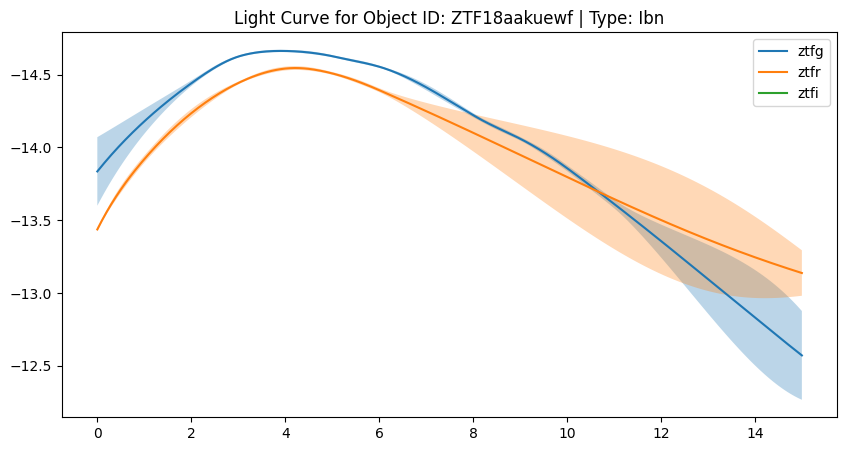

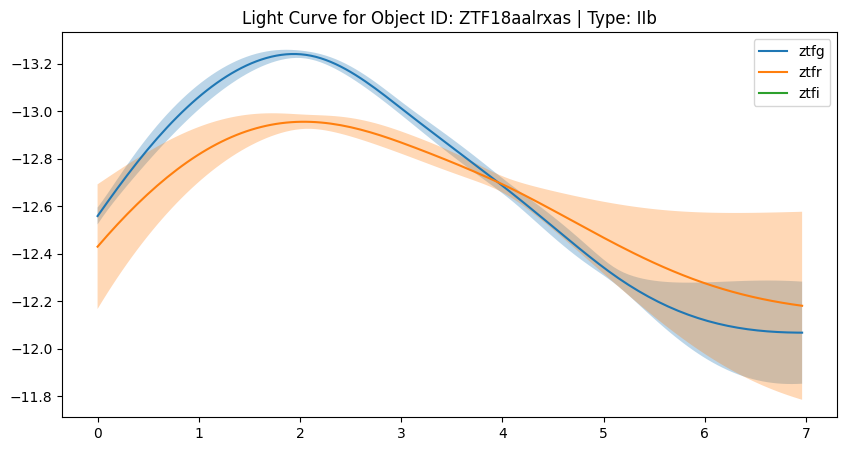

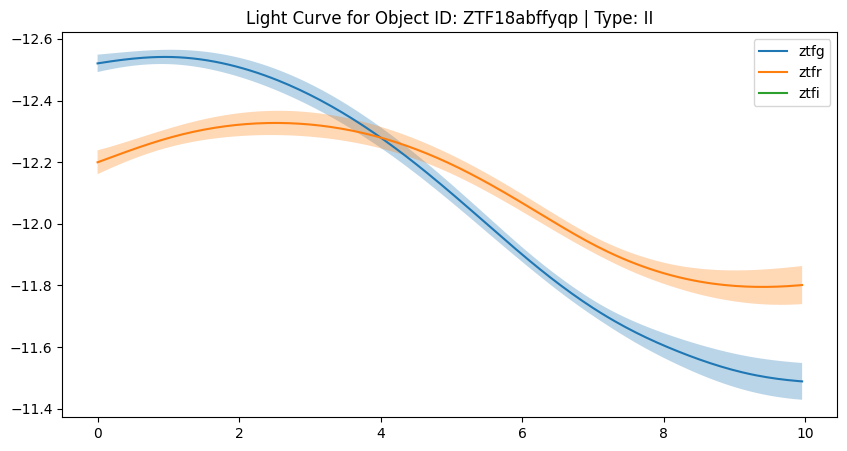

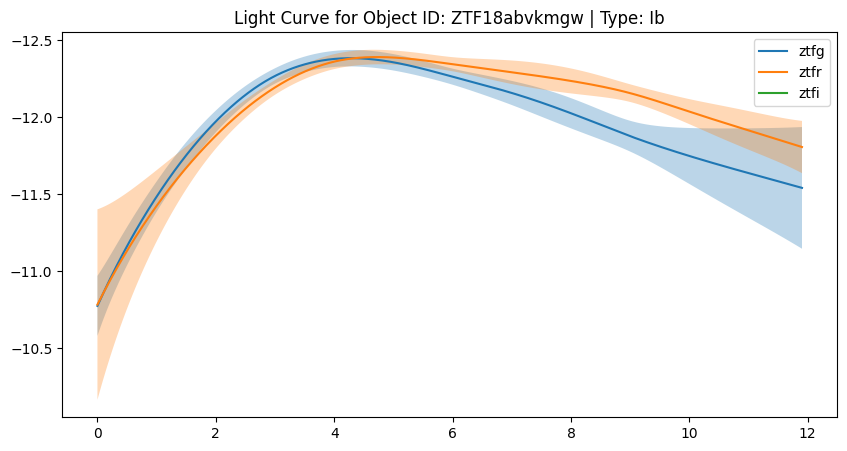

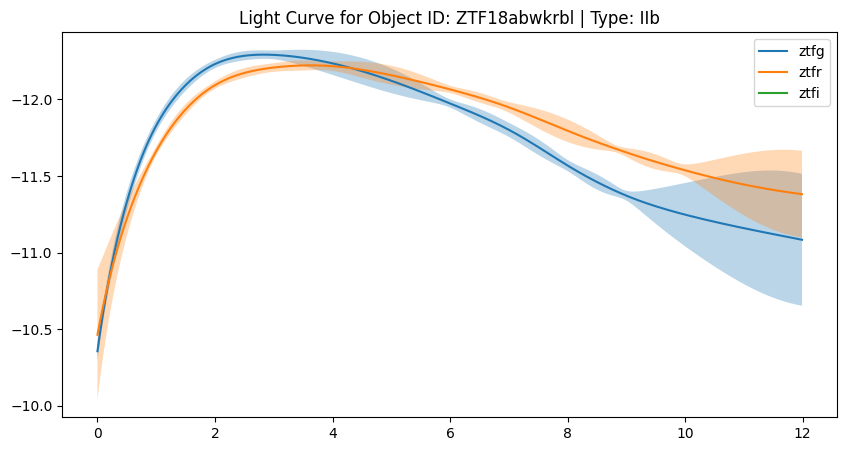

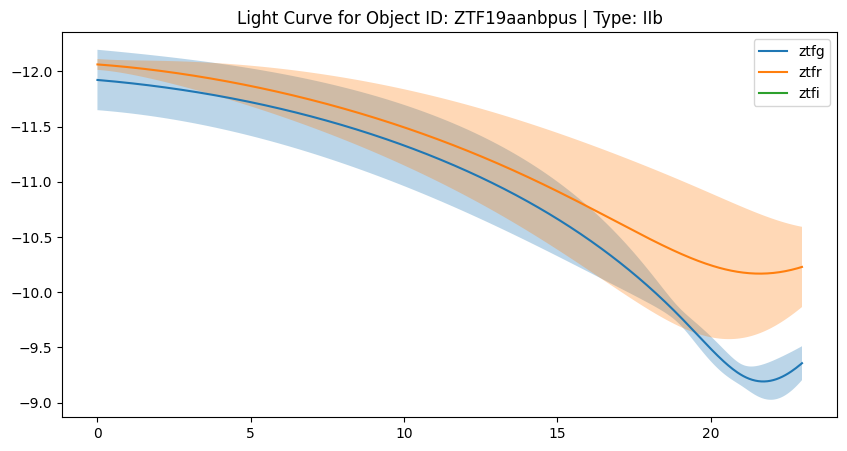

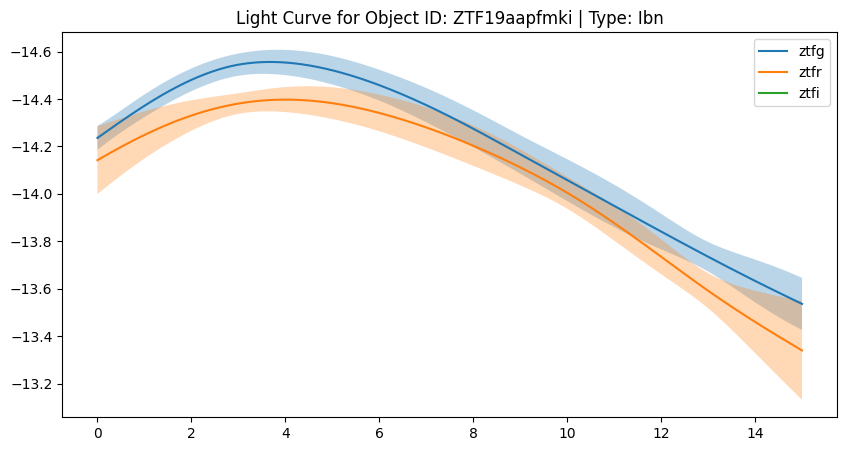

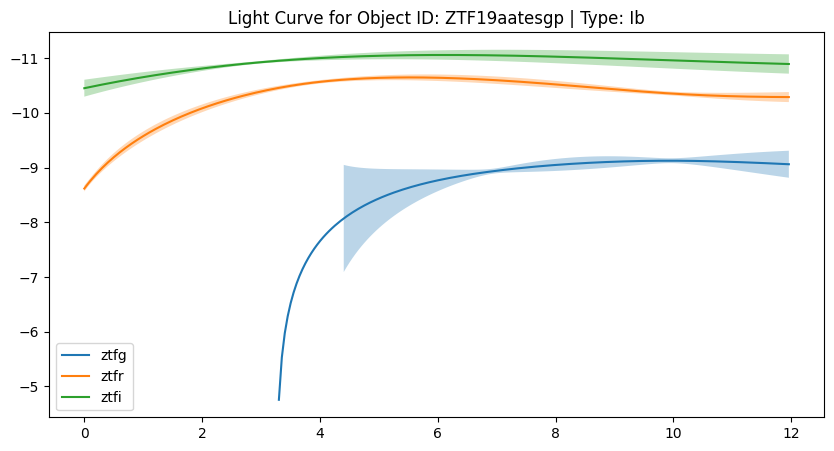

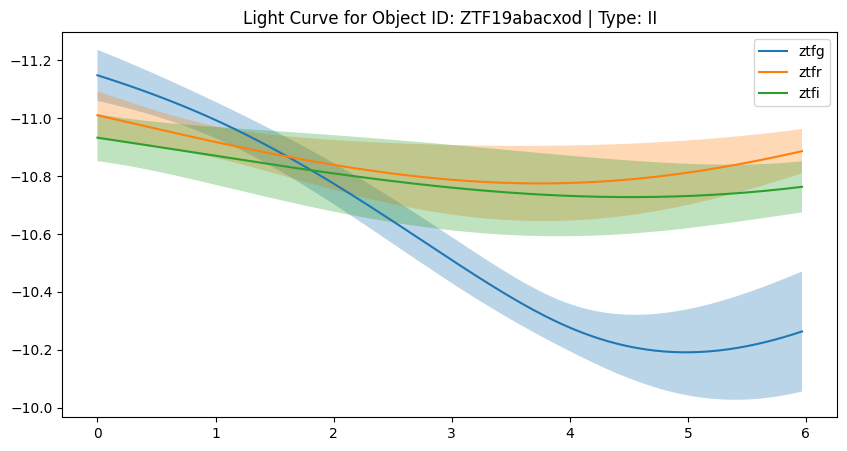

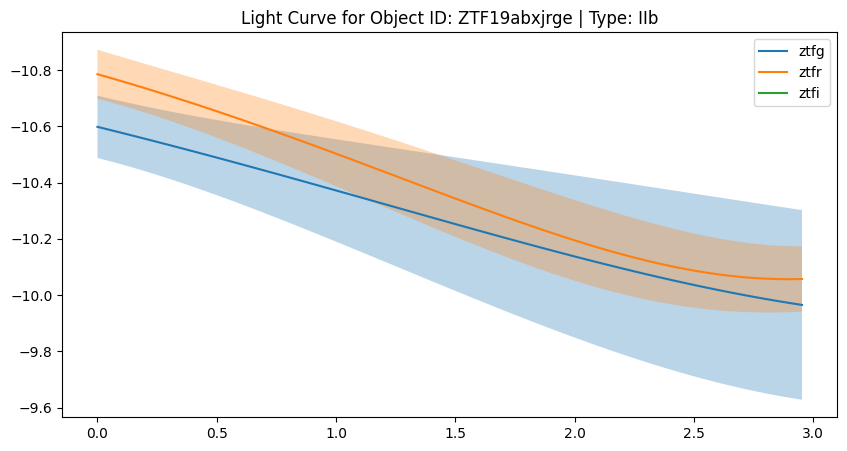

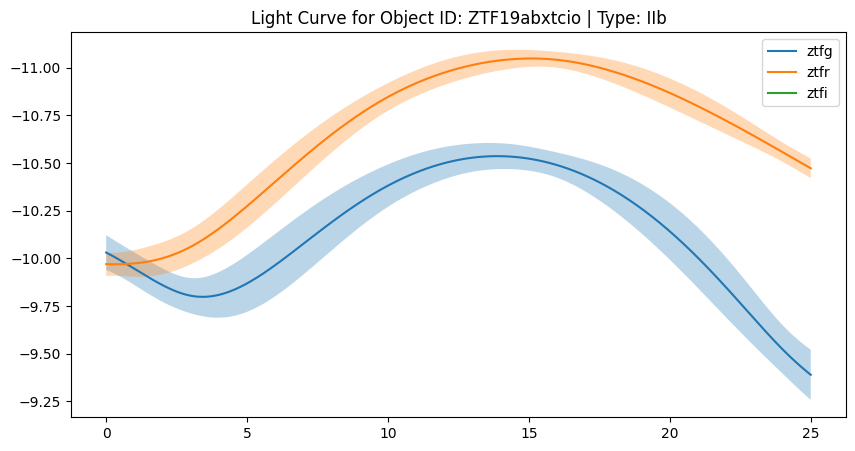

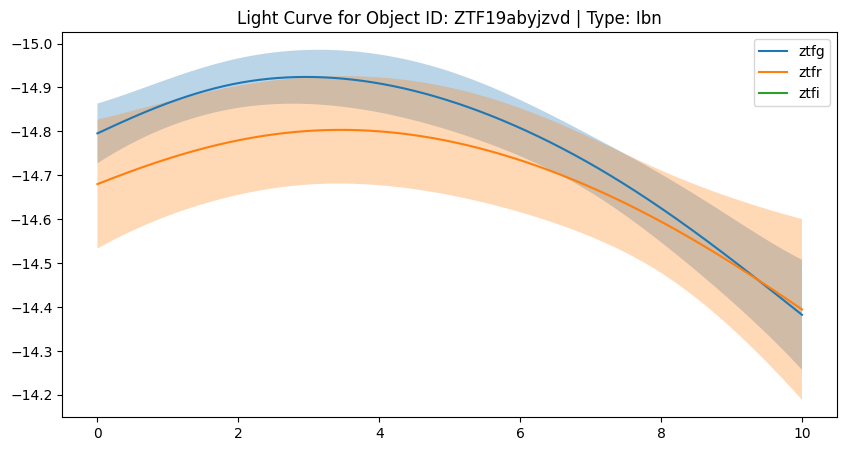

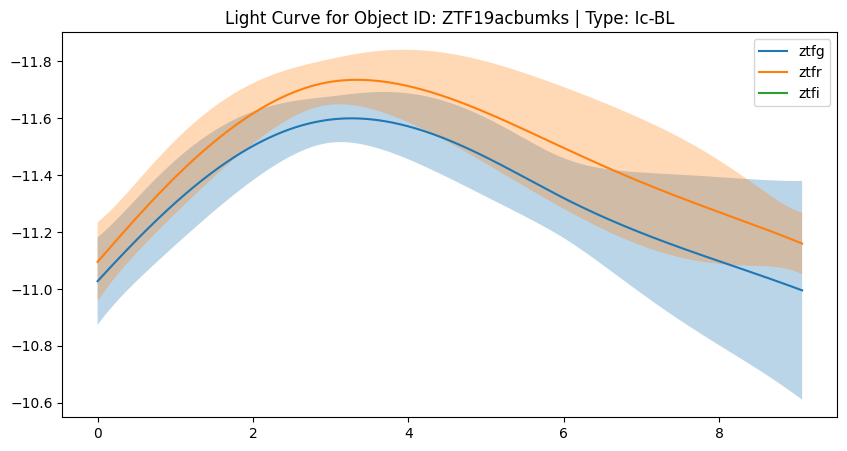

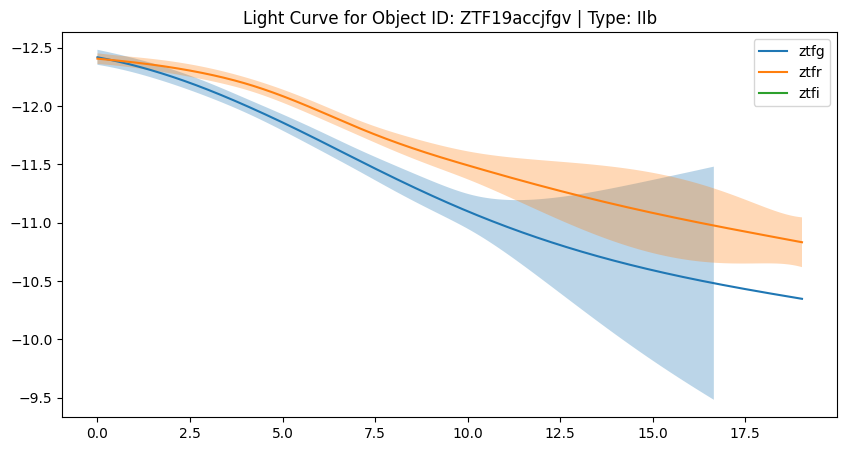

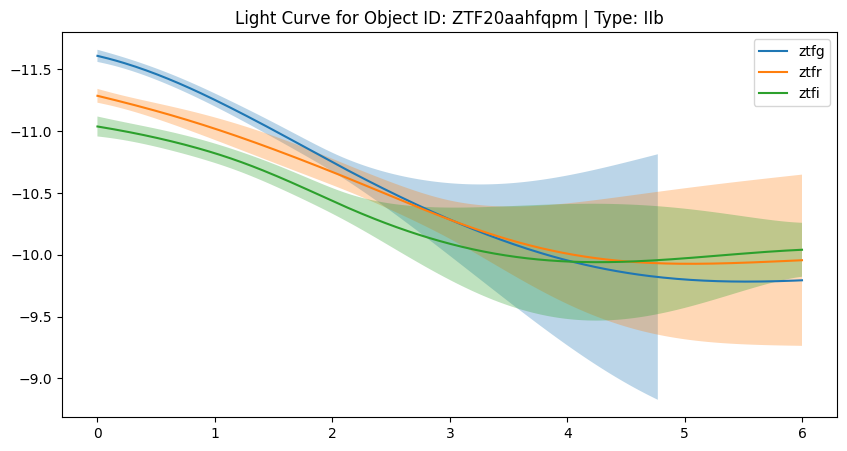

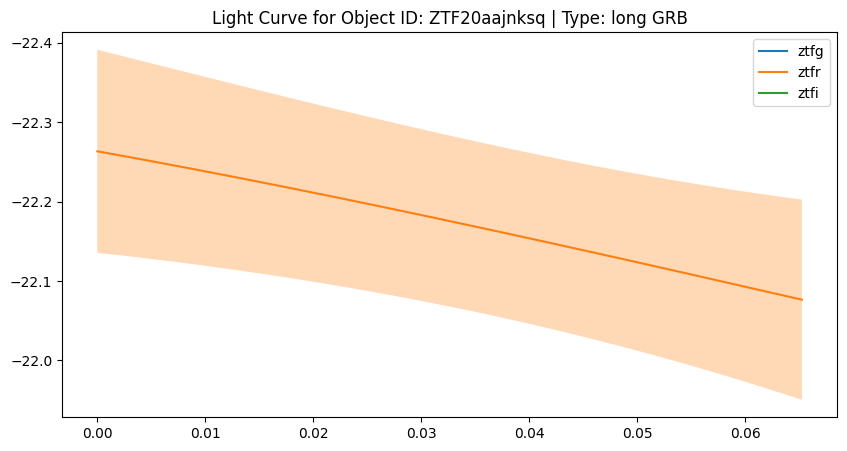

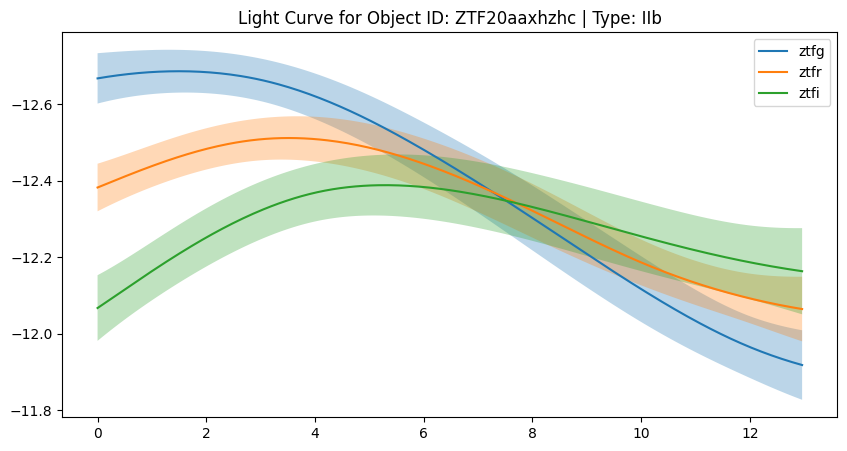

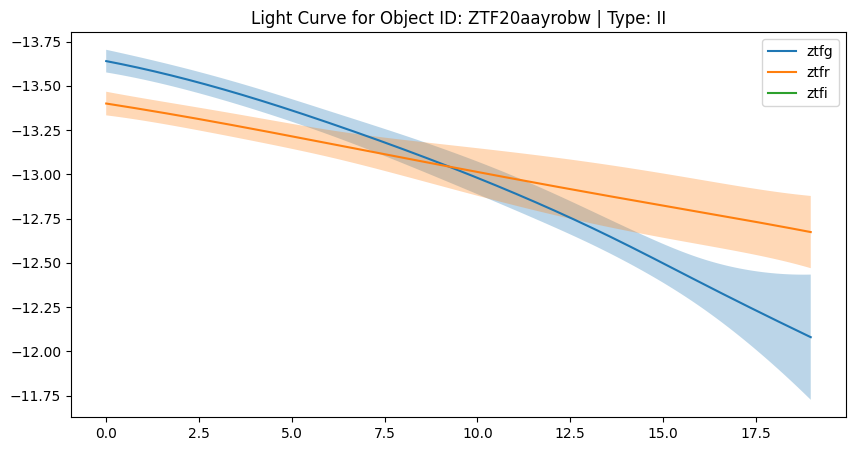

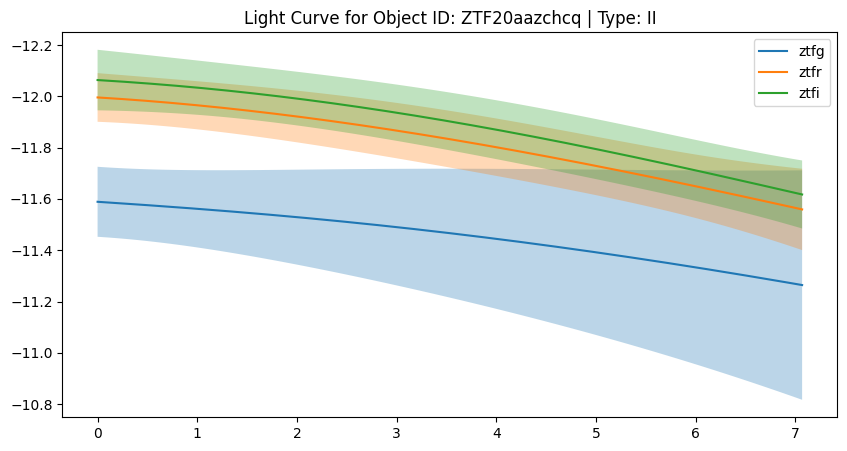

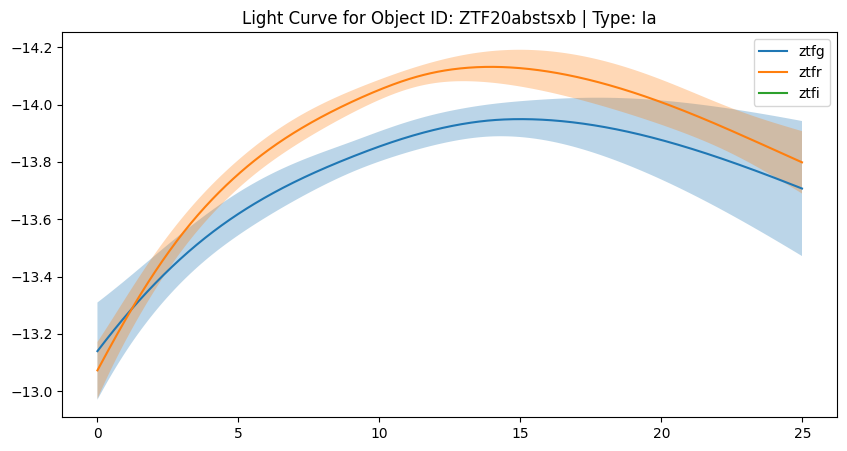

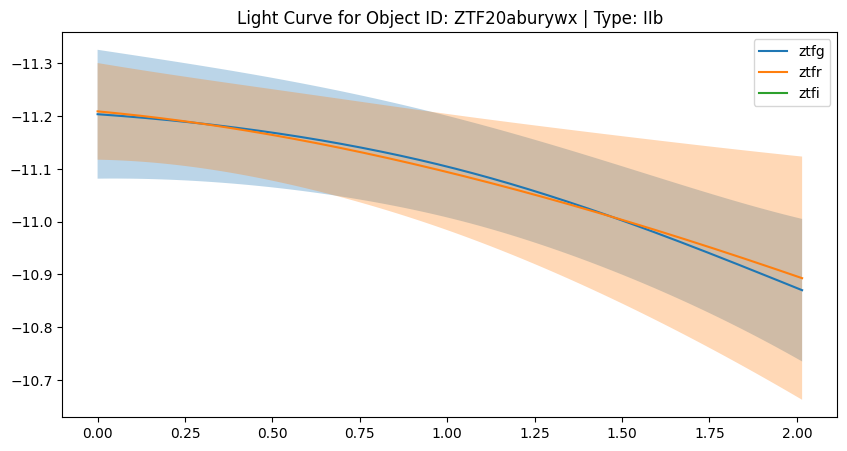

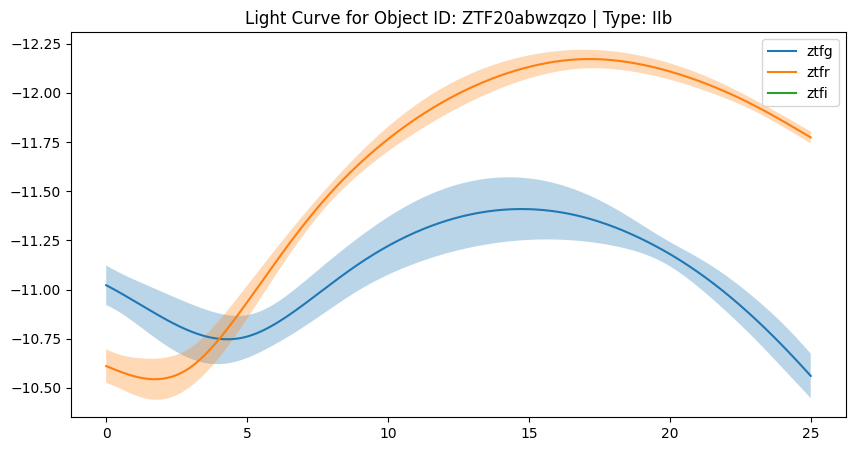

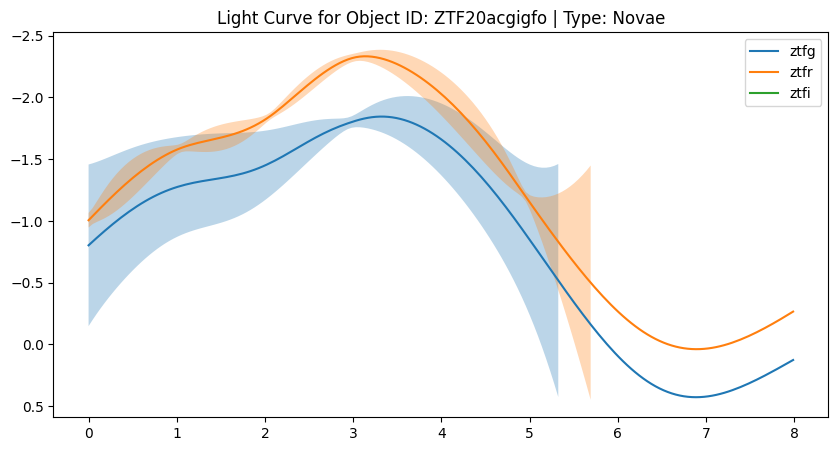

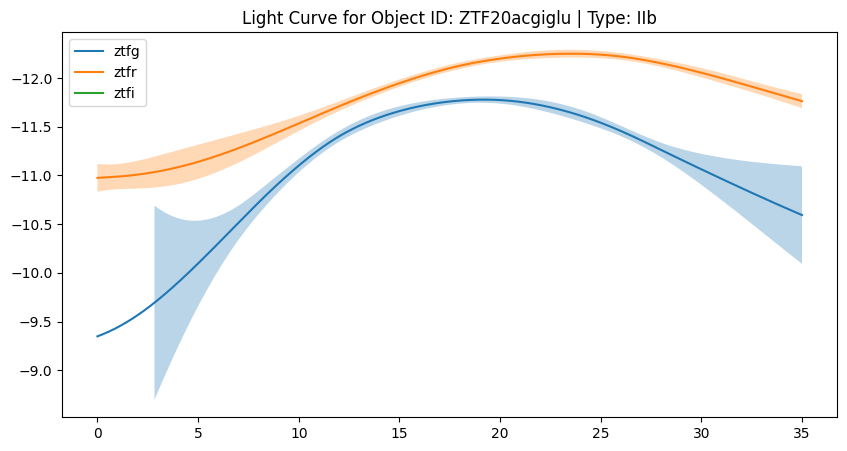

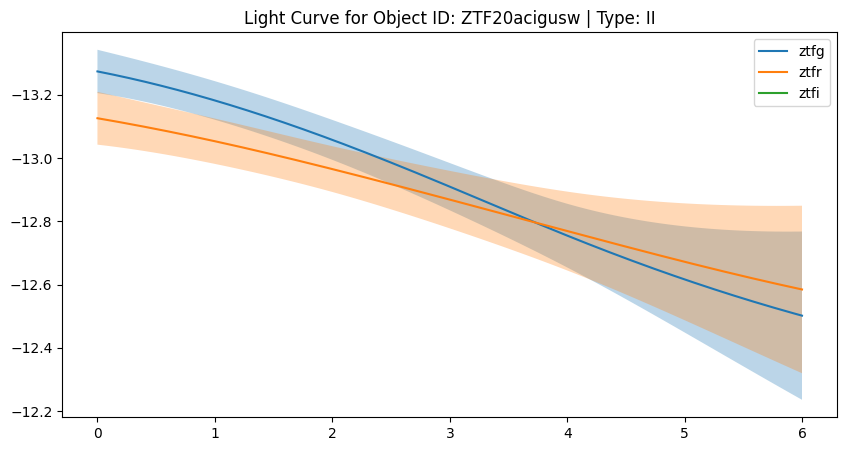

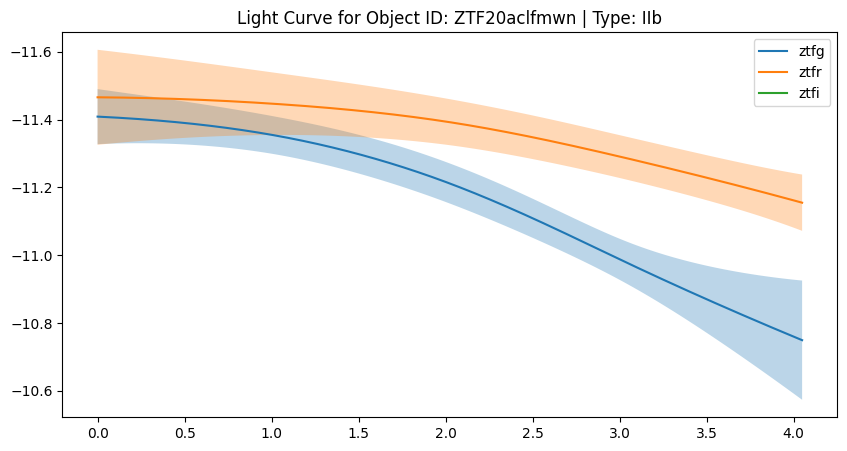

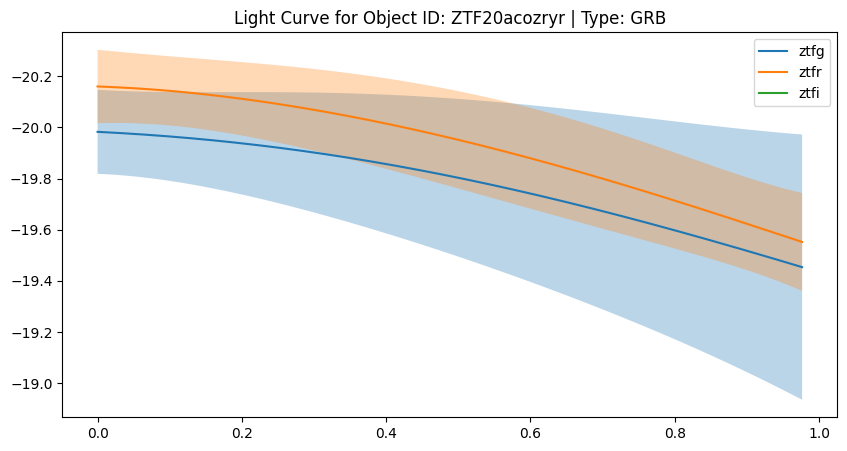

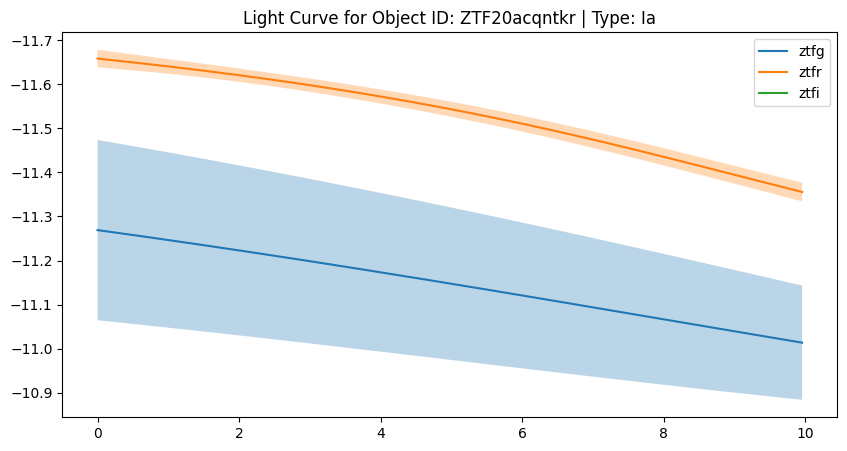

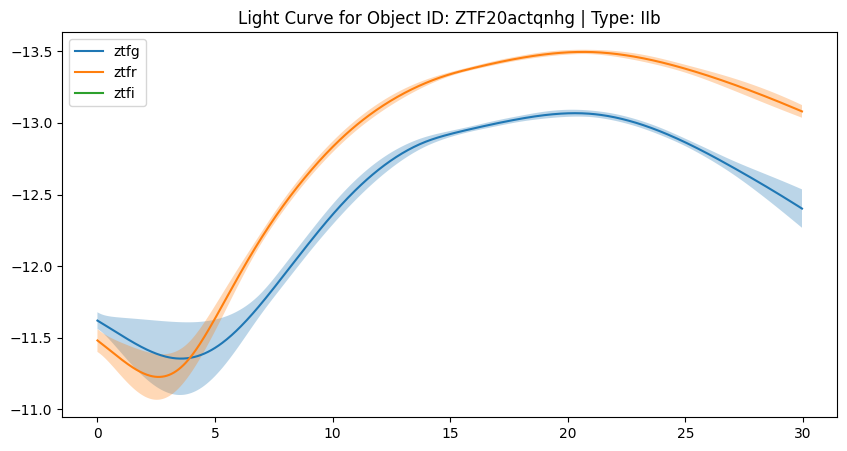

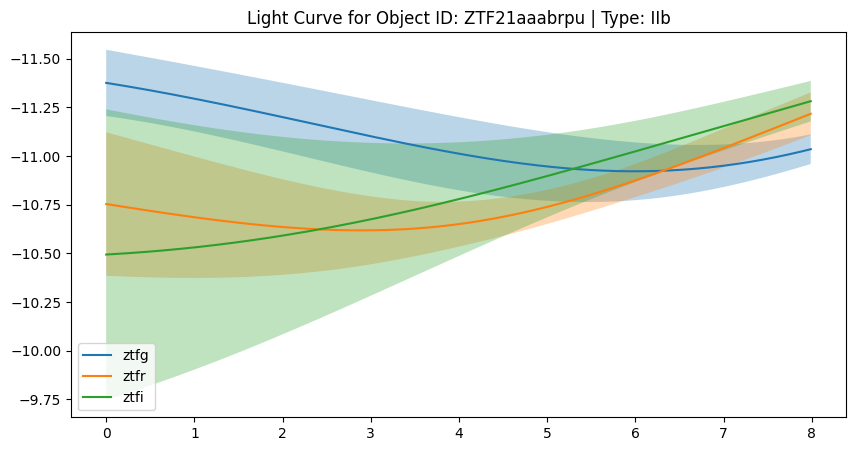

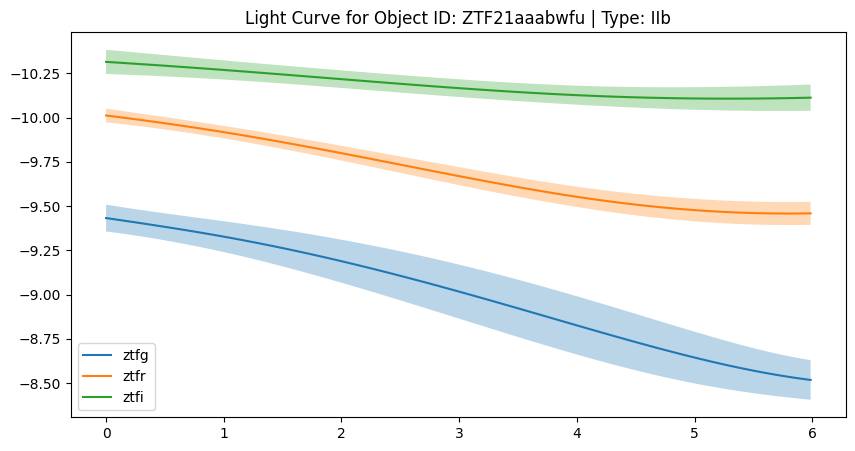

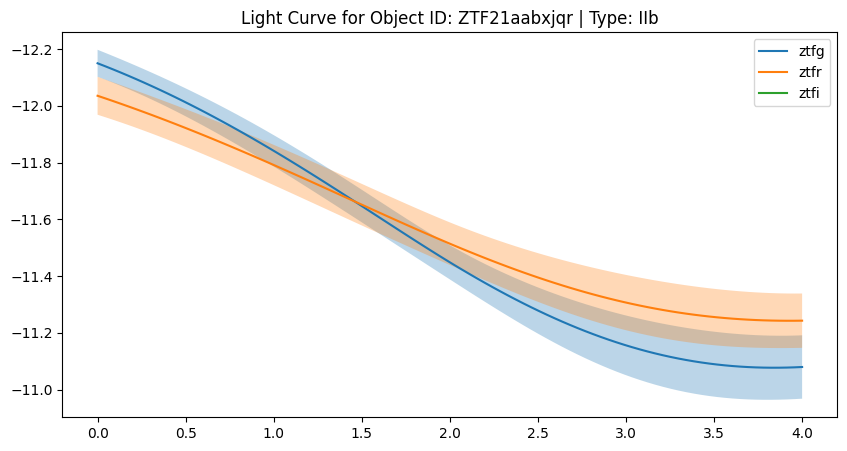

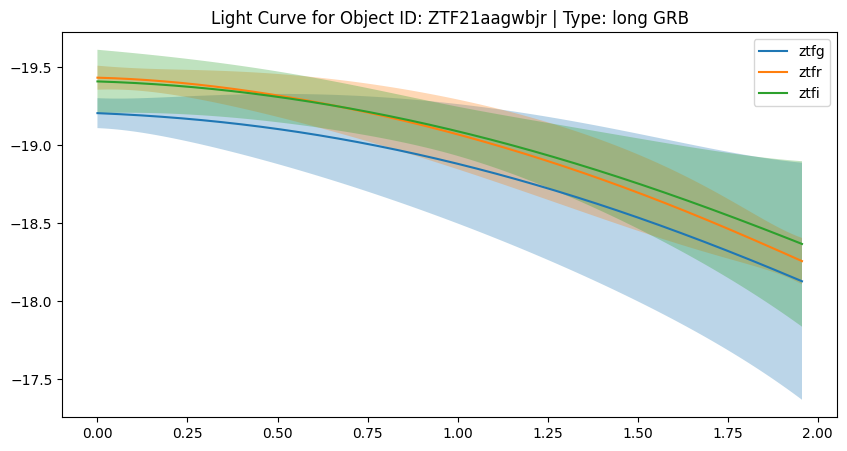

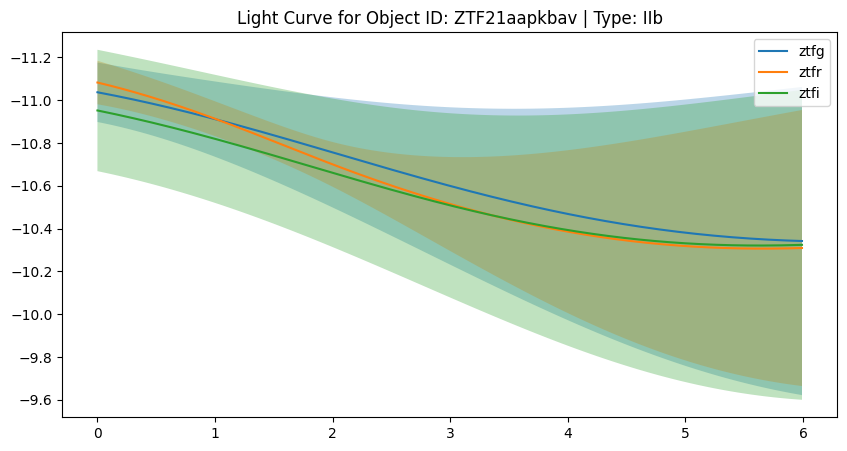

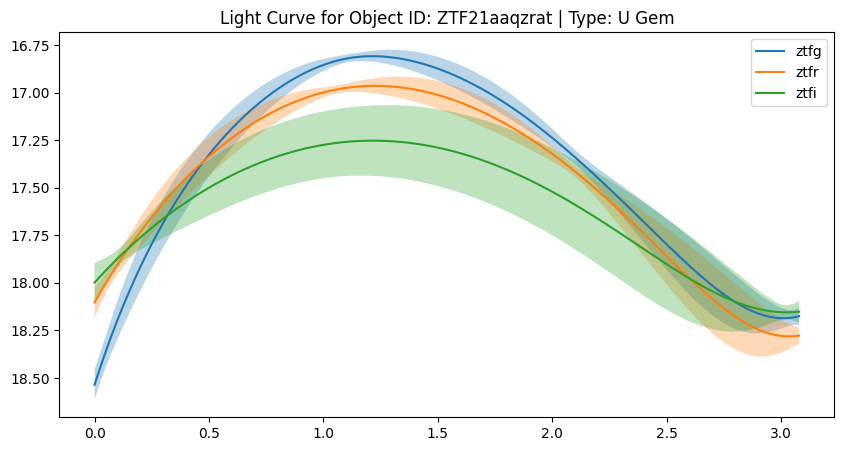

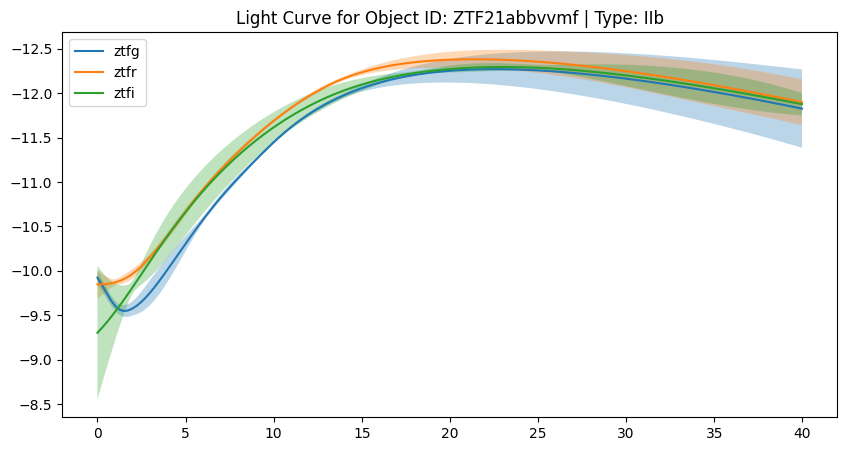

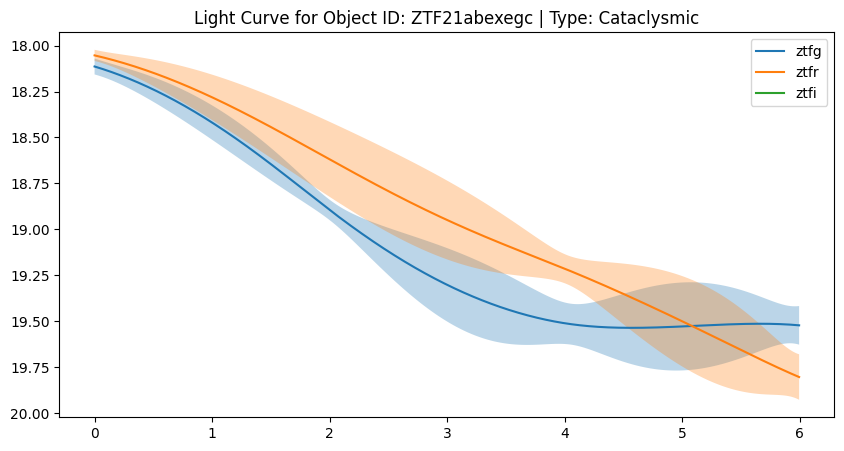

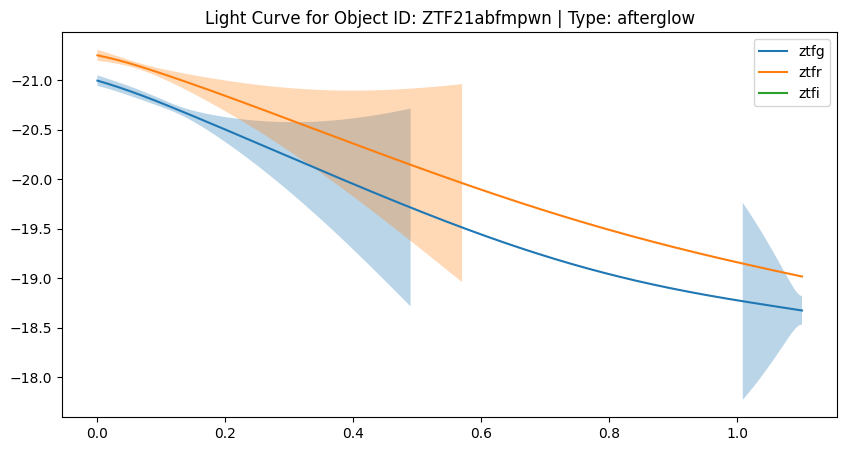

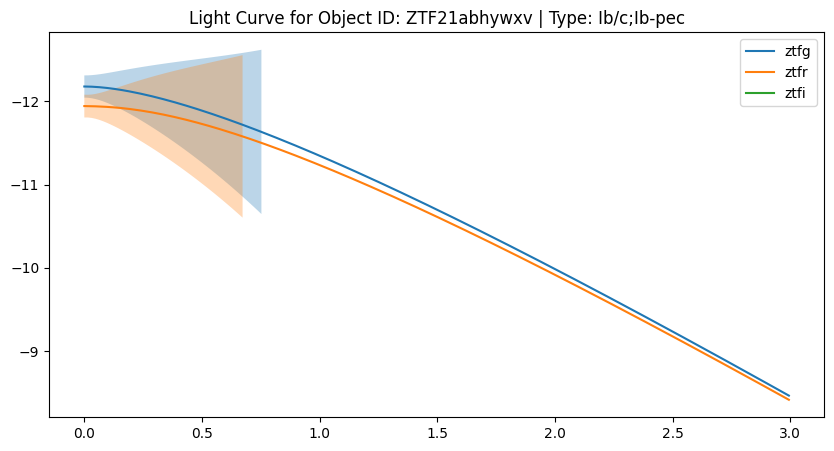

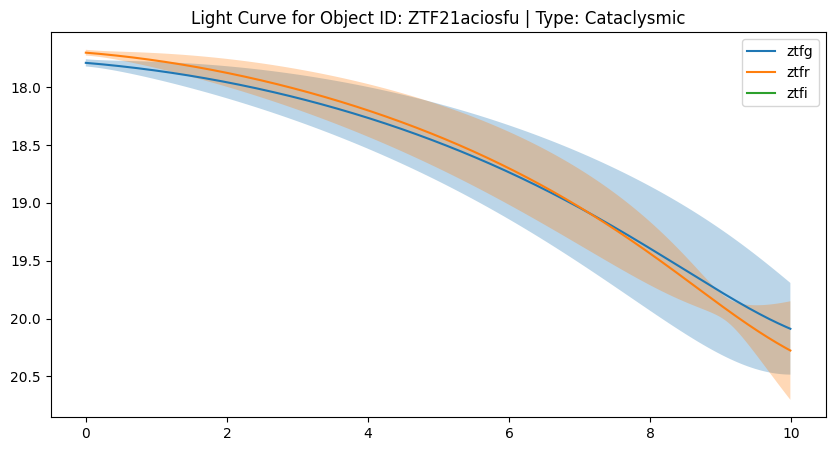

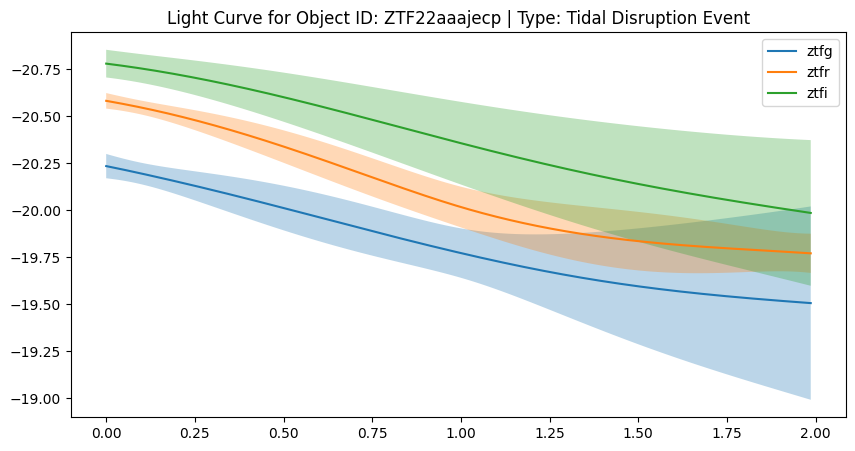

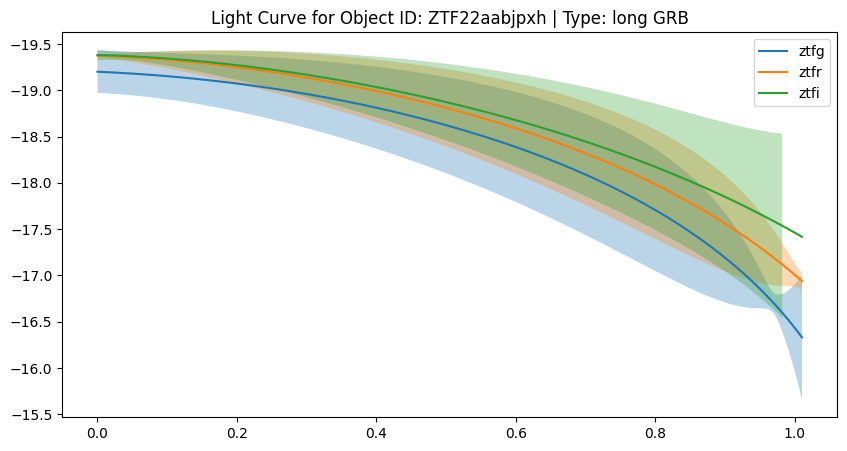

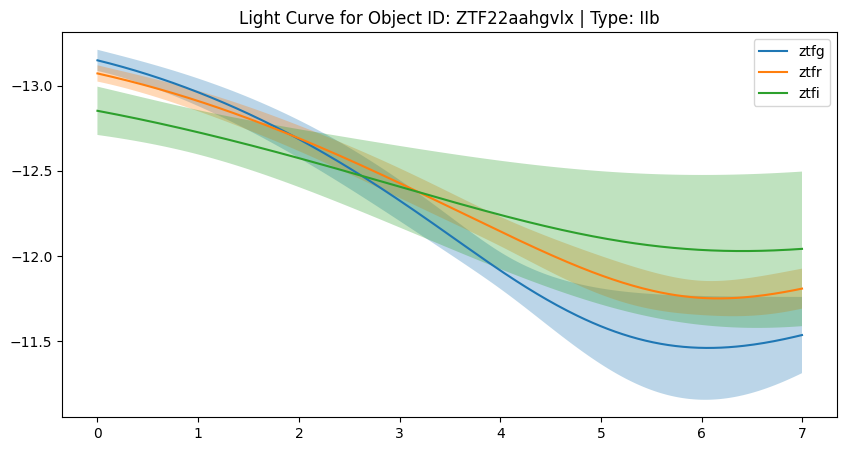

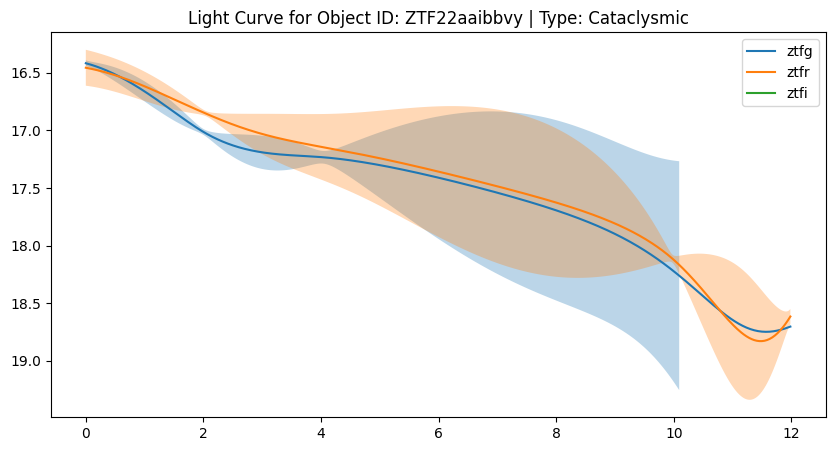

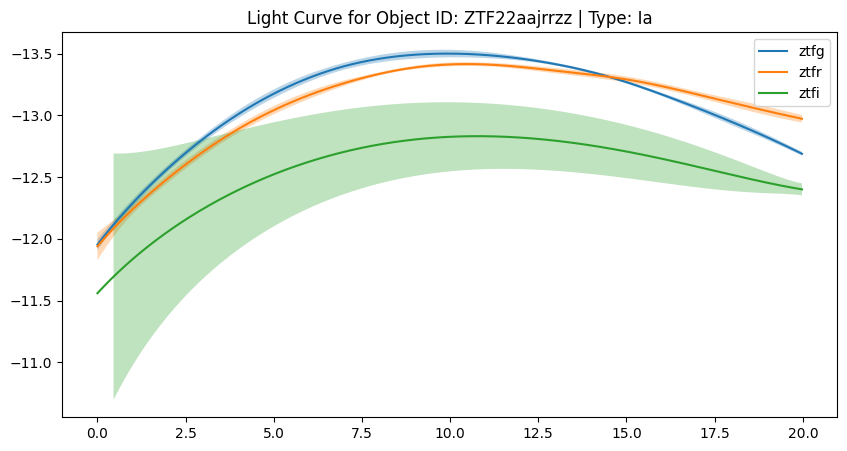

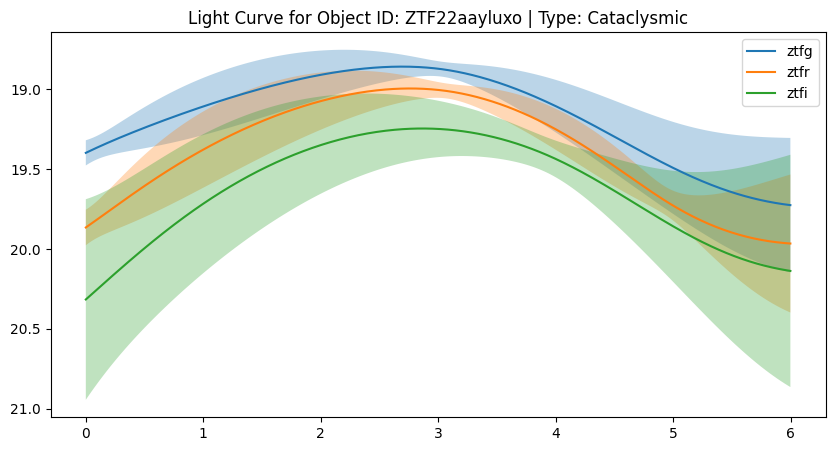

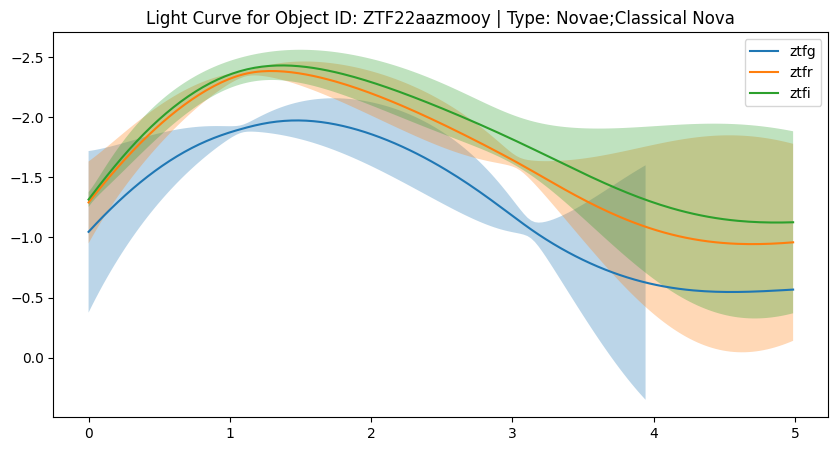

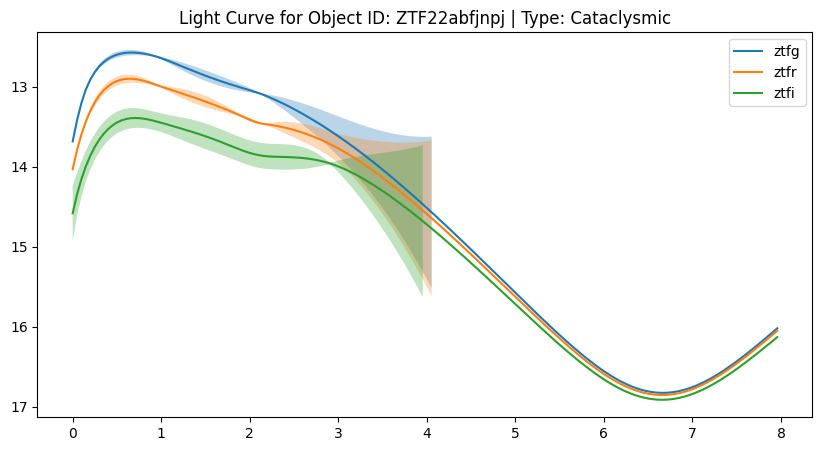

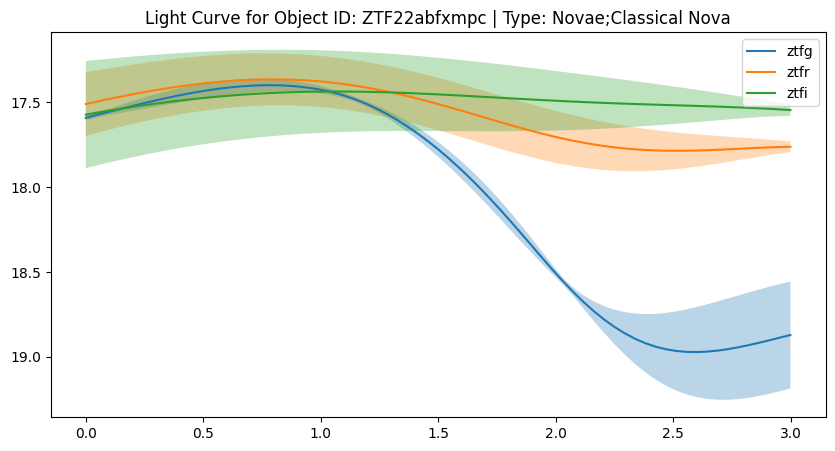

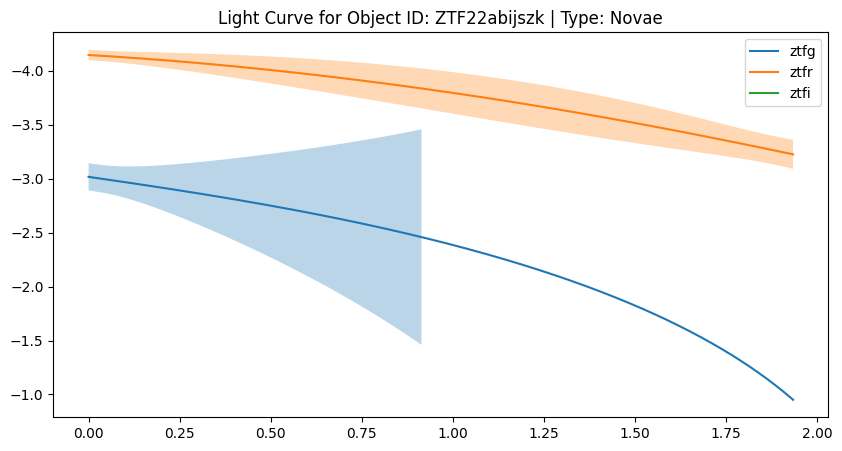

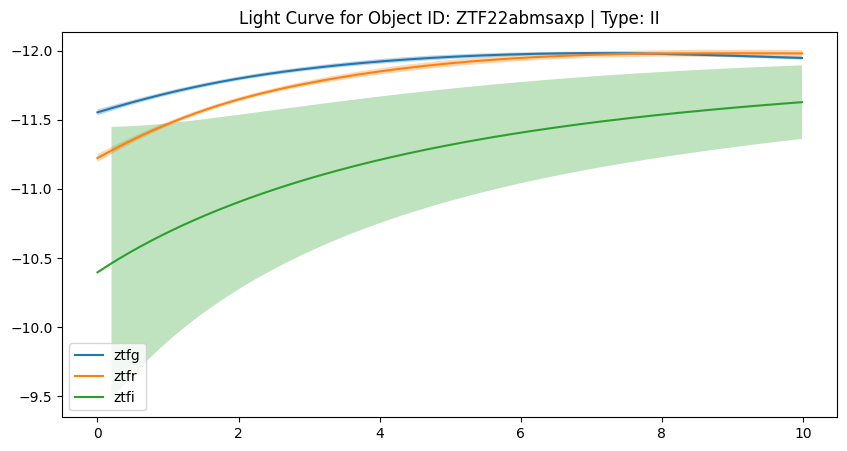

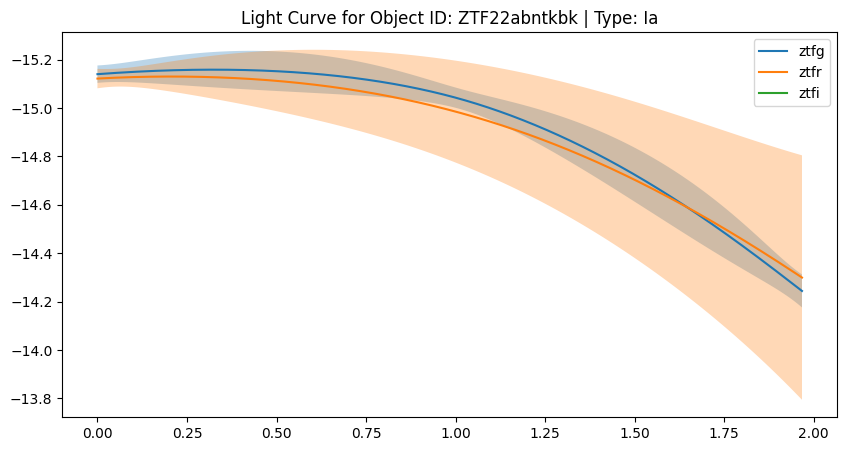

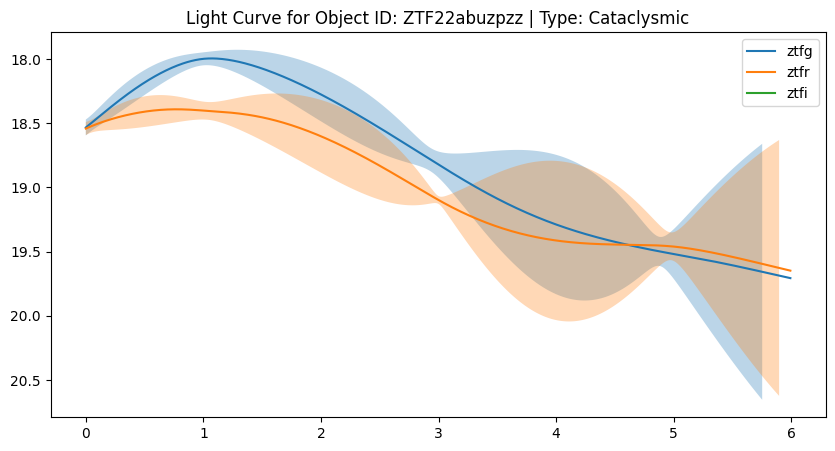

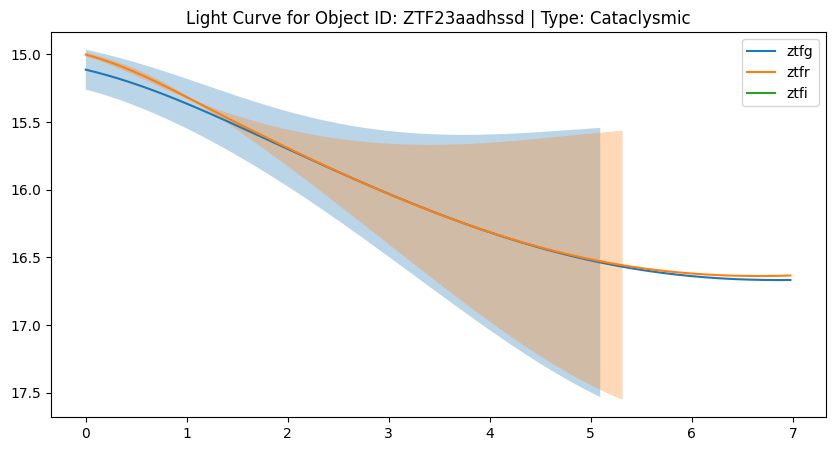

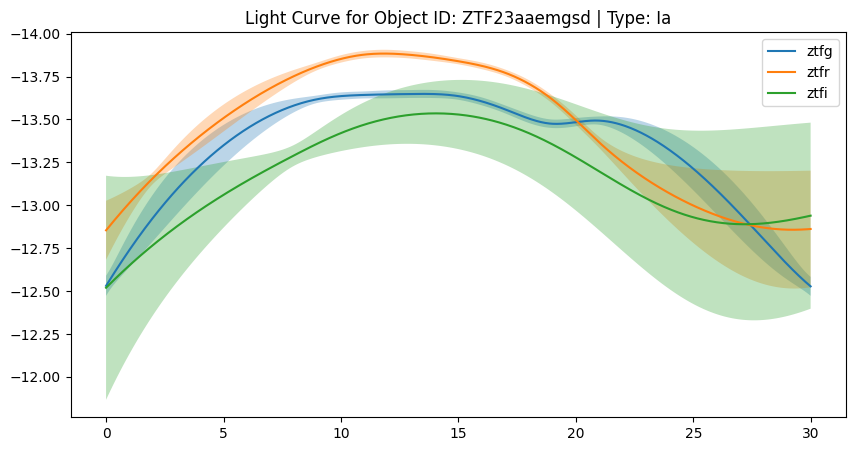

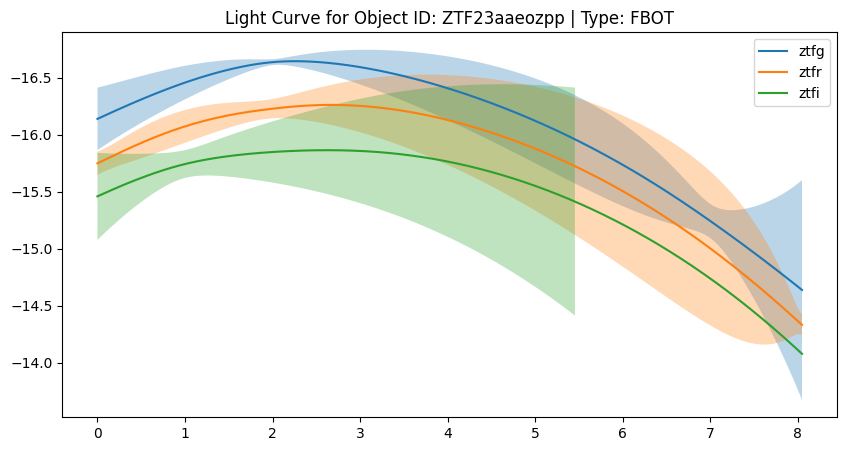

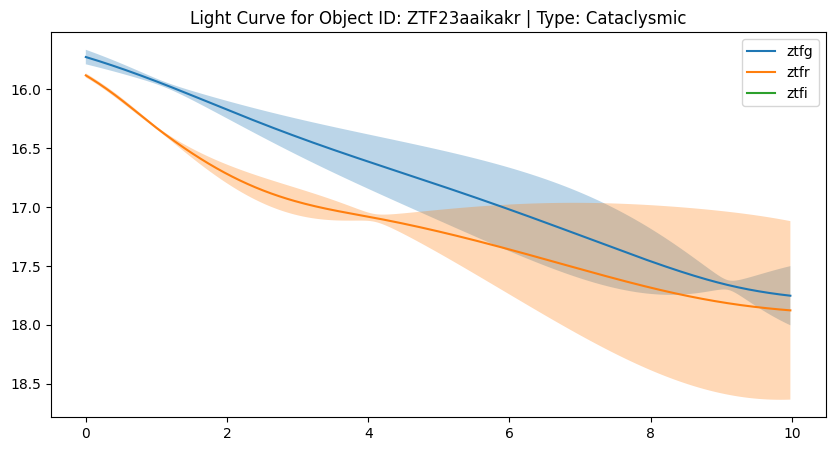

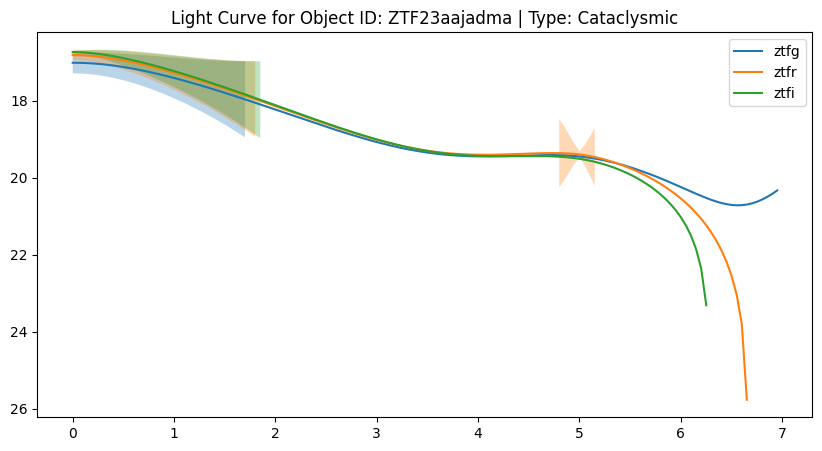

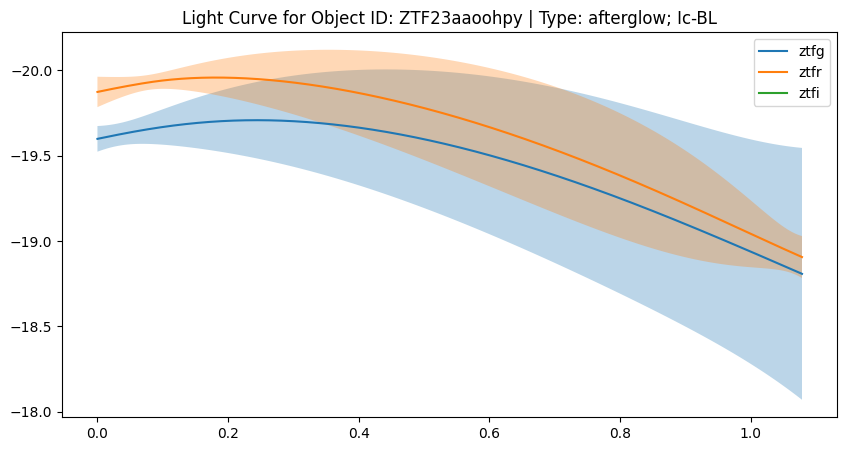

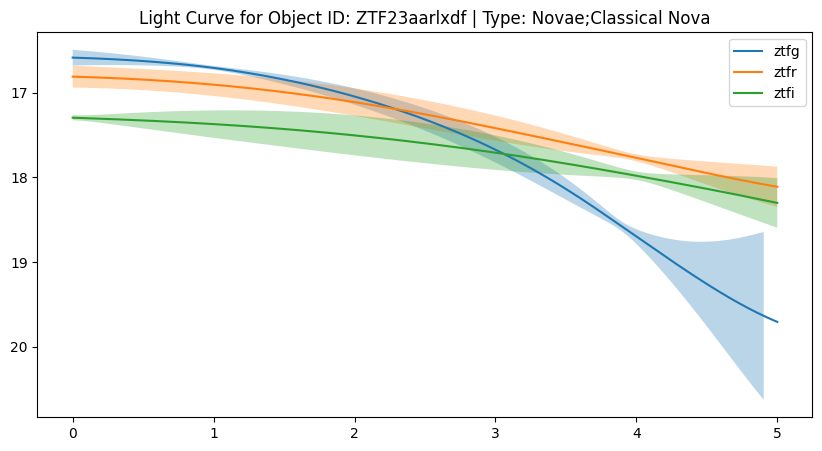

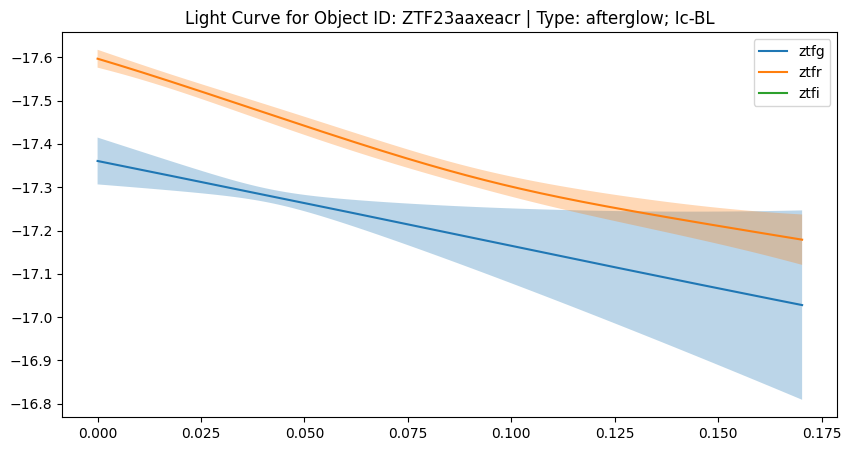

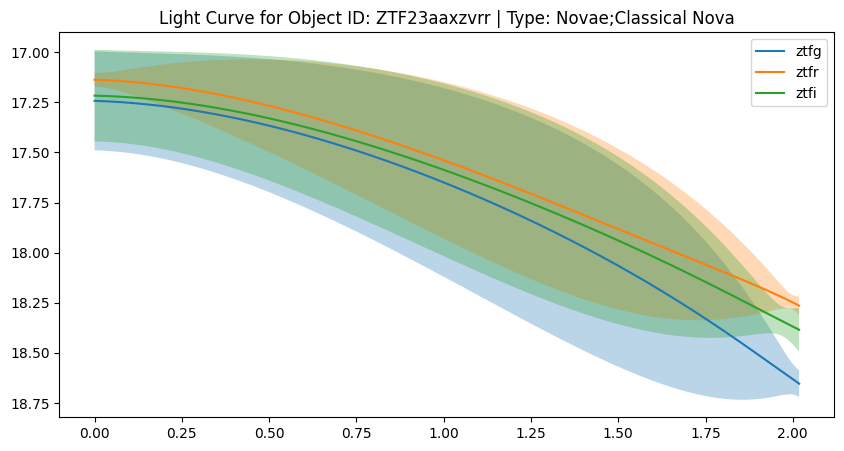

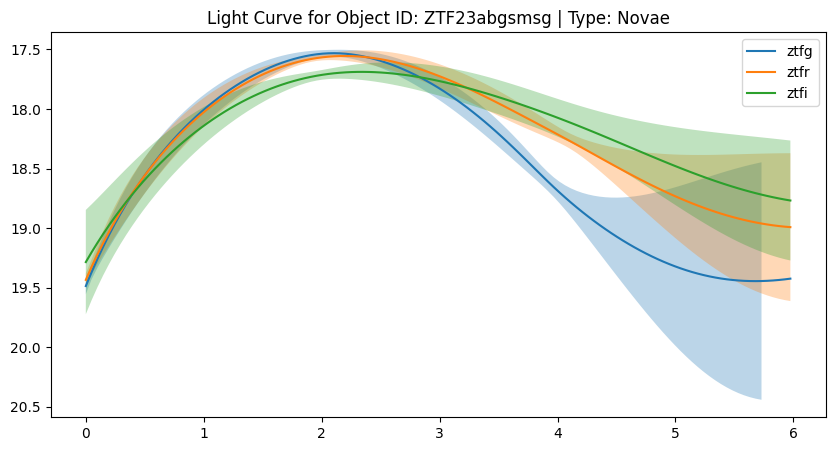

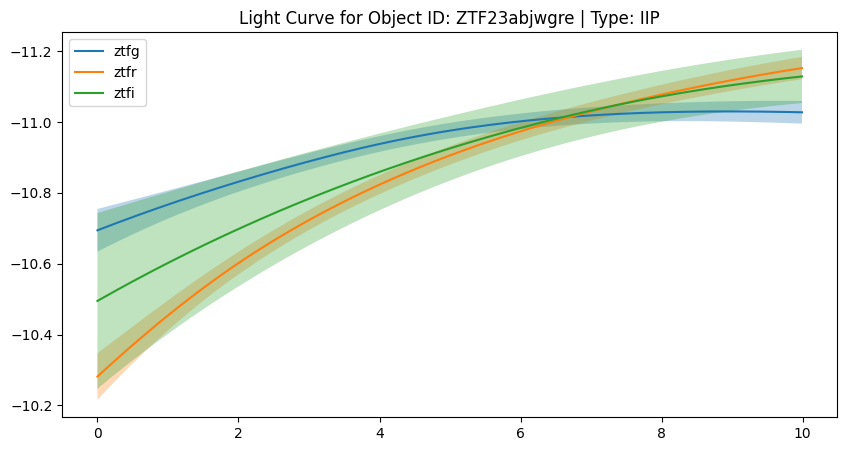

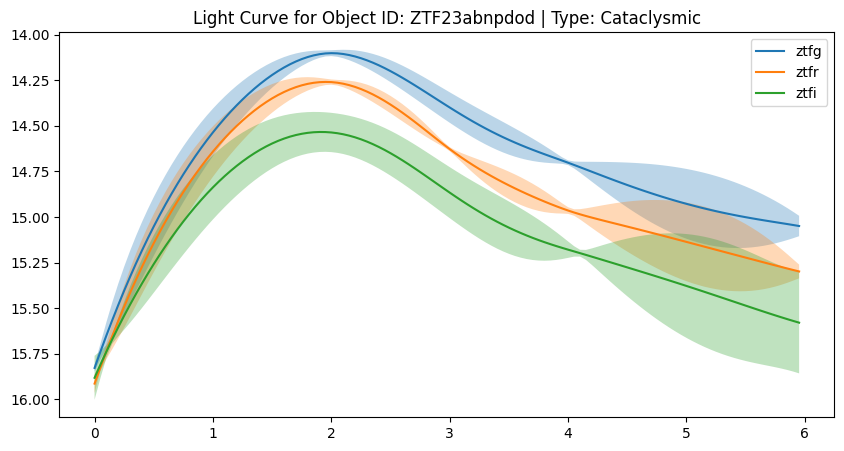

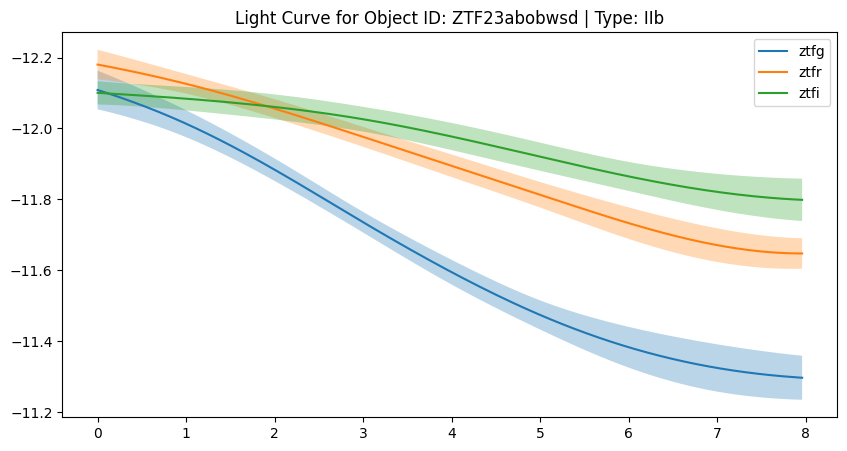

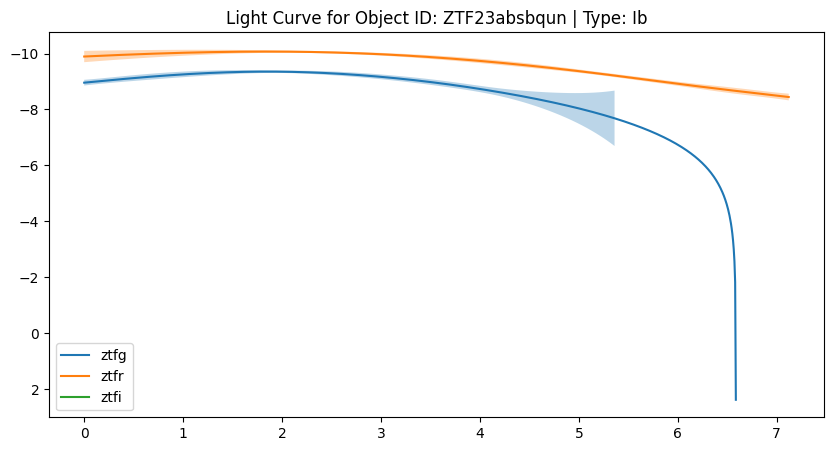

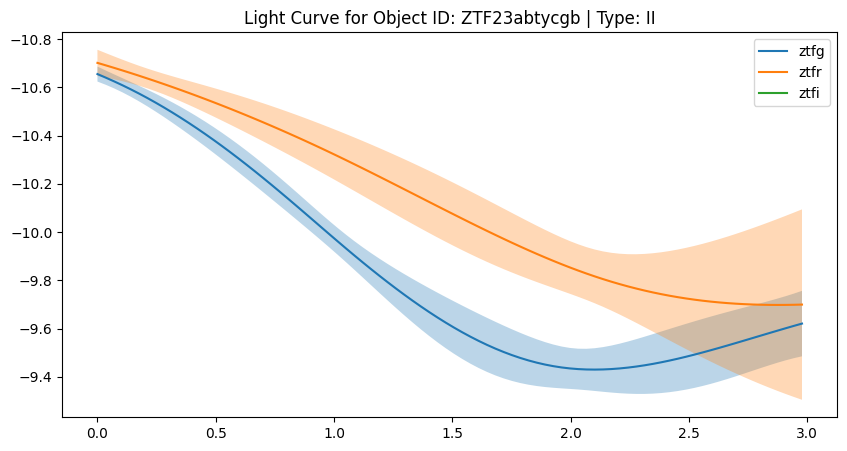

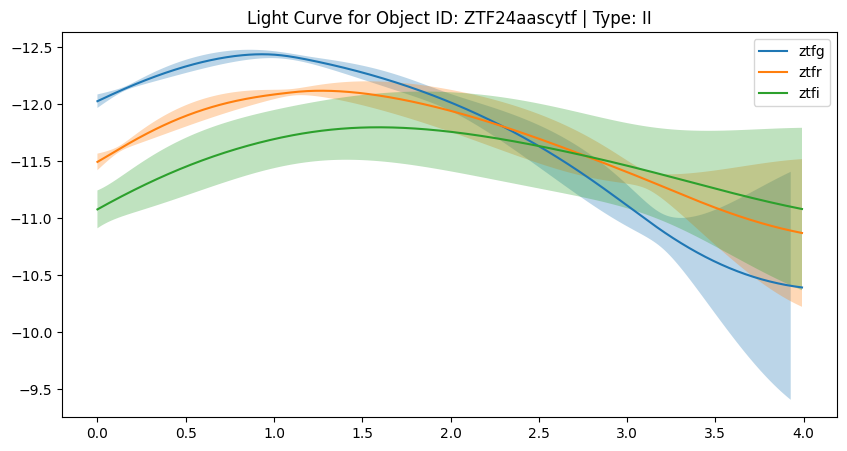

In [6]:
for obj_i in obj:
    # print(obj_i)
    df_obj = df[df.obj_id == obj_i]
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        # df_det = df_observed[(df_observed.obj_id == obj_i) & (df_observed.filter == filter) & (df_observed.t < df_obj.t.max())]
        ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
        ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
        # ax.scatter(df_det.t, df_det.absmag, c='r', s=100)
    ax.invert_yaxis()
    ax.legend()
    obj_id = df_obj['obj_id'].iloc[0]
    obj_type = df_obj['type'].iloc[0]
    ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
    plt.show()

In [7]:
def calc_peak(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the peak magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    peak_dict: dictionary of peak values/times with filters as keys
    '''
    peak_dict = {}
    
    for filt in filters:
        df_filt = df